<center><img src="https://keras.io/img/logo-small.png" alt="Keras logo" width="100"><br/>
This starter notebook is provided by the Keras team.</center>

## Keras NLP starter guide here: https://keras.io/guides/keras_nlp/getting_started/

In this competition, the challenge is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.
A dataset of 10,000 tweets that were hand classified is available. 

__This starter notebook uses the [DistilBERT](https://arxiv.org/abs/1910.01108) pretrained model from KerasNLP.__


**BERT** stands for **Bidirectional Encoder Representations from Transformers**. BERT and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models.

The BERT family of models uses the **Transformer encoder architecture** to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers.

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.

**DistilBERT model** is a distilled form of the **BERT** model. The size of a BERT model was reduced by 40% via knowledge distillation during the pre-training phase while retaining 97% of its language understanding abilities and being 60% faster.



![BERT Architecture](https://www.cse.chalmers.se/~richajo/nlp2019/l5/bert_class.png)



In this notebook, you will:

- Load the Disaster Tweets
- Explore the dataset
- Preprocess the data
- Load a DistilBERT model from Keras NLP
- Train your own model, fine-tuning BERT
- Generate the submission file


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Aug 19 21:51:35 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

!pip install ktrain==0.41.1

import ktrain
import keras as k

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 44.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 47.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 16.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 kB 32.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for ktrain: filename=ktrain-0.41.1-py3-none-any.whl size=25316900 sha256=88465c81865de7f92e8d930f61362cc9462d920611e12668aa653b624b024c99
  Stored in directory: /root/.cache/pip/wheels/b7/d8/4d/00cca

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# Load the Disaster Tweets
Let's have a look at the train and test dataset.

They contain:
- id
- keyword: A keyword from that tweet (although this may be blank!)
- location: The location the tweet was sent from (may also be blank)
- text: The text of a tweet
- target: 1 if the tweet is a real disaster or 0 if not

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
df_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [4]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [6]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


If you want to know more information about the data, you can grab useful information [here](https://www.kaggle.com/code/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert)

Note that all the tweets are in english.

# Preprocess the data

In [7]:
train, val, preprocess = ktrain.text.texts_from_df(
    df_train,
    "text",
    label_columns=["target"],
    val_df=None,
    max_features=20000,
    maxlen=250,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1,
)

['not_target', 'target']
      not_target  target
464          1.0     0.0
4246         0.0     1.0
1518         0.0     1.0
1202         0.0     1.0
761          1.0     0.0
['not_target', 'target']
      not_target  target
7458         1.0     0.0
1558         0.0     1.0
987          1.0     0.0
4830         1.0     0.0
1040         1.0     0.0


preprocessing train...
language: en
train sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 27


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 15
	95percentile : 24
	99percentile : 27


# Load a BERT model from ktrain

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT.

The BertClassifier model can be configured with a preprocessor layer, in which case it will automatically apply preprocessing to raw inputs during fit(), predict(), and evaluate(). This is done by default when creating the model with from_preset().

We will choose DistilBERT model.that learns a distilled (approximate) version of BERT, retaining 97% performance but using only half the number of parameters ([paper](https://arxiv.org/abs/1910.01108)). 

It has 40% less parameters than bert-base-uncased, runs 60% faster while preserving over 95% of BERT’s performances as measured on the GLUE language understanding benchmark.

Specifically, it doesn't have token-type embeddings, pooler and retains only half of the layers from Google's BERT.

In [12]:
import transformers

t_mod = ktrain.text.Transformer('bert-base-uncased', maxlen=250, classes = [0,1])
model =t_mod.get_classifier()


learner = ktrain.get_learner(model, train_data=train, val_data=val, batch_size=16)

/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:382: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/ktrain/text/preprocessor.py:392: UserWarning: The method preprocess_train was never called. You can disable this warning by setting preprocess_train_called=True.
  warnings.warn(


# Train your own model, fine-tuning BERT

In [9]:
learner.lr_find(max_epochs=6)

simulating training for different learning rates... this may take a few moments...
Epoch 1/6
428/428 [==============================] - 241s 498ms/step - loss: 0.7145 - accuracy: 0.5283
Epoch 2/6
428/428 [==============================] - 214s 501ms/step - loss: 0.4543 - accuracy: 0.8099
Epoch 3/6
428/428 [==============================] - 214s 499ms/step - loss: 0.5671 - accuracy: 0.6871
Epoch 4/6
428/428 [==============================] - 213s 498ms/step - loss: 1.2321 - accuracy: 0.5087
Epoch 5/6
428/428 [==============================] - 3s 5ms/step - loss: 10.9988 - accuracy: 0.5783


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


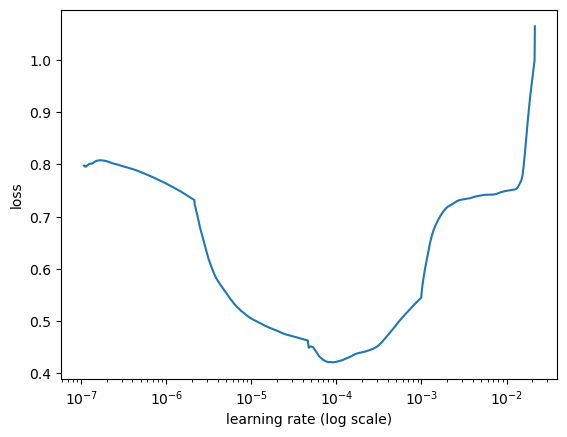

In [10]:
learner.lr_plot()

In [13]:
history=learner.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=10,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/10
429/429 [==============================] - 245s 521ms/step - loss: 0.5183 - accuracy: 0.7606 - val_loss: 0.4272 - val_accuracy: 0.8084
Epoch 2/10
429/429 [==============================] - 217s 506ms/step - loss: 0.4282 - accuracy: 0.8292 - val_loss: 0.5351 - val_accuracy: 0.7690
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [16]:
predictor = ktrain.get_predictor(learner.model, preproc=preprocess)

In [14]:
validation = learner.validate(val_data=val, print_report=True)

24/24 [==============================] - 6s 108ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       461
           1       0.76      0.75      0.76       301

    accuracy                           0.81       762
   macro avg       0.80      0.80      0.80       762
weighted avg       0.81      0.81      0.81       762



In [ ]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))


# Generate the submission file 

For each tweets in the test set, we predict if the given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

The `submission.csv` file uses the following format:
`id,target`

In [25]:
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")
sample_submission.head()
df_test

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45
...,...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,55
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,139
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,55
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,65


In [31]:
for idx in range(len(df_test["text"])) :
    pred = predictor.predict(df_test["text"][idx])
    if pred == "target" :
        sample_submission["target"][idx] = 1
    if pred == "not_target" :
        sample_submission["target"][idx] = 0

In [33]:
sample_submission.describe()

,id
count,3263.000000
mean,5427.152927
std,3146.427221
min,0.000000
25%,2683.000000
50%,5500.000000
75%,8176.000000
max,10875.000000


In [34]:
sample_submission.to_csv("submission.csv", index=False)